### Generating names with recurrent neural networks

This time you'll find yourself delving into the heart (and other intestines) of recurrent neural networks on a class of toy problems.

Struggle to find a name for the variable? Let's see how you'll come up with a name for your son/daughter. Surely no human has expertize over what is a good child name, so let us train RNN instead;

It's dangerous to go alone, take these:

In [1]:
import sys
if 'google.colab' in sys.modules:
    import os

    os.system('apt-get install -y xvfb')
    os.system('wget https://raw.githubusercontent.com/yandexdataschool/Practical_RL/spring20/xvfb -O ../xvfb')
    os.system('apt-get install -y python-opengl ffmpeg')
    os.system('pip install pyglet==1.2.4')

    os.system('python -m pip install -U pygame --user')

    print('setup complete')

    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/spring20/week07_[recap]_rnn/names

# XVFB will be launched if you run on a server
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

setup complete
Starting virtual X frame buffer: Xvfb.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Our data
The dataset contains ~8k earthling names from different cultures, all in latin transcript.

This notebook has been designed so as to allow you to quickly swap names for something similar: deep learning article titles, IKEA furniture, pokemon names, etc.

In [3]:
import os
start_token = " "

with open("names") as f:
    lines = f.read()[:-1].split('\n')
    lines = [start_token + name for name in lines]

In [4]:
print(len(lines))
print(lines[0])
print(lines[0:3])
print(lines[::1000]) #every X element


7944
 Abagael
[' Abagael', ' Abagail', ' Abbe']
[' Abagael', ' Claresta', ' Glory', ' Liliane', ' Prissie', ' Geeta', ' Giovanne', ' Piggy']


In [5]:
print('n samples = ', len(lines))
for x in lines[::1000]:
    print(x)

n samples =  7944
 Abagael
 Claresta
 Glory
 Liliane
 Prissie
 Geeta
 Giovanne
 Piggy


max length = 16


(array([1.900e+01, 2.720e+02, 0.000e+00, 9.260e+02, 0.000e+00, 1.878e+03,
        0.000e+00, 2.049e+03, 0.000e+00, 1.447e+03, 0.000e+00, 8.460e+02,
        0.000e+00, 3.510e+02, 0.000e+00, 1.160e+02, 0.000e+00, 2.400e+01,
        0.000e+00, 1.000e+01, 0.000e+00, 3.000e+00, 0.000e+00, 1.000e+00,
        2.000e+00]),
 array([ 3.  ,  3.52,  4.04,  4.56,  5.08,  5.6 ,  6.12,  6.64,  7.16,
         7.68,  8.2 ,  8.72,  9.24,  9.76, 10.28, 10.8 , 11.32, 11.84,
        12.36, 12.88, 13.4 , 13.92, 14.44, 14.96, 15.48, 16.  ]),
 <a list of 25 Patch objects>)

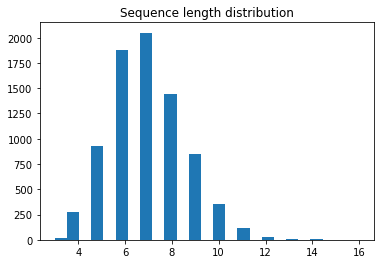

In [6]:
MAX_LENGTH = max(map(len, lines))
print("max length =", MAX_LENGTH)

plt.title('Sequence length distribution')
plt.hist(list(map(len, lines)), bins=25)

# Text processing

First we need next to collect a "vocabulary" of all unique tokens i.e. unique characters. We can then encode inputs as a sequence of character ids.

In [7]:
tokens = []
l = [list(np.unique([x for x in word])) for word in lines]
for word in lines:
    l = list(np.unique([x for x in word]))
    tokens = list(np.unique(tokens + l))

print(tokens)

[' ', "'", '-', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [8]:
# get all unique characters from lines (including capital letters and symbols)
tokens = []
l = [list(np.unique([x for x in word])) for word in lines]
for word in lines:
    l = list(np.unique([x for x in word]))
    tokens = list(np.unique(tokens + l))

n_tokens = len(tokens)
print('n_tokens = ', n_tokens)

assert 50 < n_tokens < 60

n_tokens =  55


### Cast everything from symbols into identifiers

Tensorflow string manipulation is a bit tricky, so we'll work around it. 
We'll feed our recurrent neural network with ids of characters from our dictionary.

To create such dictionary, let's assign each character with it's index in tokens list.

In [9]:
# dictionary of symbol -> its identifier (index in tokens list)
token_to_id = {x:i for i,x in enumerate(tokens)}

In [10]:
assert len(tokens) == len(token_to_id), "dictionaries must have same size"
for i in range(n_tokens):
    assert token_to_id[tokens[i]] == i, "token identifier must be it's position in tokens list"

print("Seems alright!")

Seems alright!


In [11]:
def to_matrix(names, max_len=None, pad=token_to_id[' '], dtype='int32'):
    """Casts a list of names into rnn-digestable matrix"""
    max_len = max_len or max(map(len, names))
    names_ix = np.zeros([len(names), max_len], dtype) + pad

    for i in range(len(names)):
        name_ix = list(map(token_to_id.get, names[i]))
        names_ix[i, :len(name_ix)] = name_ix

    return names_ix

In [12]:
# Example: cast 4 random names to matrices, pad with zeros
print('\n'.join(lines[::2000]))
print(to_matrix(lines[::2000]))

 Abagael
 Glory
 Prissie
 Giovanne
[[ 0  3 30 29 35 29 33 40  0]
 [ 0  9 40 43 46 53  0  0  0]
 [ 0 18 46 37 47 47 37 33  0]
 [ 0  9 37 43 50 29 42 42 33]]


# Recurrent neural network

We can rewrite recurrent neural network as a consecutive application of dense layer to input $x_t$ and previous rnn state $h_t$. This is exactly what we're gonna do now.
<img src="https://github.com/yandexdataschool/Practical_RL/blob/master/week07_%5Brecap%5D_rnn/rnn.png?raw=1" width=480>

Since we're training a language model, there should also be:
* An embedding layer that converts character ids x_t to a vector.
* An output layer that predicts probabilities of next token

In [13]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

import keras
import keras.layers as L

emb_size, rnn_size = 16, 64

# an embedding layer that converts character ids into embeddings
embed_x = L.Embedding(n_tokens, emb_size)

# a dense layer that maps input and previous state to new hidden state, [x_t,h_t] -> h_t+1
get_h_next = L.Dense(rnn_size, activation='tanh')

# a dense layer that maps current hidden state to probabilities of characters [h_t+1]->P(x_t+1|h_t+1)
get_probas = L.Dense(n_tokens, activation='softmax')

Instructions for updating:
non-resource variables are not supported in the long term
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [ ]:
# Our Goal is to design the following algo:

# input:     ivan
# answer:    [one_hot(v),           one_hot(a),        one_hot(n)]
# predicted: [rnn_1(emb(i)), rnn_2(emb(v),h_1), rnn_3(emb(a),h_2), rnn_3(emb(n),h_3)]

In [14]:
def rnn_one_step(x_t, h_t):
    """
    Recurrent neural network step that produces next state and output
    given prev input and previous state.
    We'll call this method repeatedly to produce the whole sequence.
    :param x_t: token vector, int32[batch_size,]
    :param h_t: previous state matrix, float32[batch_size, rnn_size]

    Follow isntructions to complete the function.
    """
    #batch_size = x_t.shape[0]
    #print('batch_size: ', batch_size)

    # 1. convert character id into embedding (use embed_x layer)
    x_t_emb = embed_x(tf.reshape(x_t, [-1, 1]))[:, 0]
    #print('x_t_emb: ', x_t_emb.shape)
    
    # 2. concatenate x _embedding_ and previous h state (over last axis)
    r_t = tf.concat((x_t_emb, h_t), axis=-1)
    #print('r_t: ', r_t.shape)

    # 3. compute next state given h and x embedding
    next_h = get_h_next(r_t)
    #print('next_h: ', next_h.shape)

    # 4. get probabilities for language model P(x_next | h_next)
    next_probas = get_probas(next_h)
    #print('next_probas: ', next_probas)

    return next_h, next_probas

In [15]:
input_sequence = tf.placeholder('int32', (None, MAX_LENGTH))
batch_size = tf.shape(input_sequence)[0]

# initial hidden state
h0 = tf.zeros([batch_size, rnn_size])

In [16]:
# TEST: single rnn step
h1, p_y1 = rnn_one_step(input_sequence[:, 0], h0)

dummy_data = np.arange(MAX_LENGTH * 2).reshape([2, -1])

sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

test_h1, test_p_y1 = sess.run([h1, p_y1],  {input_sequence: dummy_data})

assert test_h1.shape == (len(dummy_data), rnn_size)
assert test_p_y1.shape == (len(dummy_data), n_tokens) and np.allclose(test_p_y1.sum(-1), 1)

### RNN loop

Once rnn_one_step is ready, let's apply it in a loop over name characters to get predictions.

Let's assume that all names are at most of length 16 for now, so we can simply iterate over them in a for loop.




In [17]:
h_prev = h0
temp_predicted_probas = []

for t in range(MAX_LENGTH):
    x_t = input_sequence[:, t]

    # Task: compute next token probas and next hidden state
    h_next, probas_next = rnn_one_step(x_t, h_prev)
    # END OF YOUR CODE

    temp_predicted_probas.append(probas_next)
    h_prev = h_next

predicted_probas = tf.stack(temp_predicted_probas, axis=1)

In [18]:
assert predicted_probas.shape.as_list() == [None, MAX_LENGTH, n_tokens]
assert h_prev.shape.as_list() == h0.shape.as_list()

## RNN: loss and gradients

Let's gather a matrix of predictions for $P(x_{next}|h)$ and the corresponding correct answers.

Our network can then be trained by minimizing crossentropy between predicted probabilities and those answers.

In [19]:
# input:     ivan
# answer:    [one_hot(v), one_hot(a), one_hot(n)] )
# predicted: [dist(x), dist(y), dist(z)]

predictions_matrix = predicted_probas[:, :-1]
answers_matrix = tf.one_hot(input_sequence[:, 1:], n_tokens)

print('predictions_matrix:', predictions_matrix.shape)
print('answers_matrix:', predictions_matrix.shape)

predictions_matrix: (?, 15, 55)
answers_matrix: (?, 15, 55)


In [20]:
# define loss as categorical crossentropy. Mind that predictions are probabilities and NOT logits!
loss = tf.reduce_mean(tf.keras.losses.categorical_crossentropy(
    answers_matrix, predictions_matrix, from_logits=False))

optimize = tf.train.AdamOptimizer().minimize(loss)

### The training loop

In [21]:
from IPython.display import clear_output
from random import sample
sess.run(tf.global_variables_initializer())

history = []

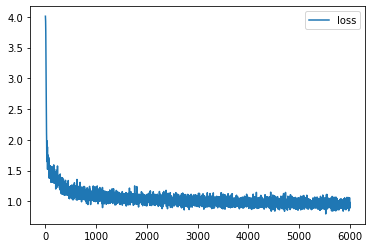

In [22]:
for i in range(6000):
    batch = to_matrix(sample(lines, 32), max_len=MAX_LENGTH)

    loss_i, _ = sess.run([loss, optimize], {input_sequence: batch})

    history.append(loss_i)
    if (i+1) % 100 == 0:
        clear_output(True)
        plt.plot(history, label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

### RNN: sampling
Once we've trained our network a bit, let's get to actually generating stuff. All we need is the `rnn_one_step` function you have written above.

In [23]:
x_t = tf.placeholder('int32', (None,))
h_t = tf.Variable(np.zeros([1, rnn_size], 'float32'))

next_h, next_probs = rnn_one_step(x_t, h_t)

In [24]:
def generate_sample(seed_phrase=' ', max_length=MAX_LENGTH):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''
    x_sequence = [token_to_id[token] for token in seed_phrase]
    sess.run(tf.variables_initializer([h_t]))

    # feed the seed phrase, if any
    for ix in x_sequence[:-1]:
        sess.run(tf.assign(h_t, next_h), {x_t: [ix]})

    # start generating
    for _ in range(max_length - len(seed_phrase)):
        x_probs, _ = sess.run([next_probs, tf.assign(h_t, next_h)], {
                              x_t: [x_sequence[-1]]})
        x_sequence.append(np.random.choice(n_tokens, p=x_probs[0]))

    return ''.join([tokens[ix] for ix in x_sequence])

In [25]:
for _ in range(10):
    print(generate_sample())

 Morill         
 Shari          
 Ausila         
 Windald        
 Berry          
 Redgoe         
 Linn           
 Durnah         
 Kio            
 Mawl           


In [26]:
for _ in range(20):
    print(generate_sample(' Trump'))

 Trumpha        
 Trumphy        
 Trumpyn        
 Trumphett      
 Trumph         
 Trumphere      
 Trumpiel       
 Trumprilu      
 Trumpie        
 Trumpir        
 Trumpie        
 Trumpi         
 Trumpup        
 Trumph         
 Trumpe         
 Trumpil        
 Trumphi        
 Trumpastt      
 Trumpon        
 Trumpie        


### Try it out!
You've just implemented a recurrent language model that can be tasked with generating any kind of sequence, so there's plenty of data you can try it on:

* Novels/poems/songs of your favorite author
* News titles/clickbait titles
* Source code of Linux or Tensorflow
* Molecules in [smiles](https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system) format
* Melody in notes/chords format
* Ikea catalog titles
* Pokemon names
* Cards from Magic, the Gathering / Hearthstone

If you're willing to give it a try, here's what you wanna look at:
* Current data format is a sequence of lines, so a novel can be formatted as a list of sentences. Alternatively, you can change data preprocessing altogether.
* While some datasets are readily available, others can only be scraped from the web. Try `Selenium` or `Scrapy` for that.
* Make sure MAX_LENGTH is adjusted for longer datasets. There's also a bonus section about dynamic RNNs at the bottom.
* More complex tasks require larger RNN architecture, try more neurons or several layers. It would also require more training iterations.
* Long-term dependencies in music, novels or molecules are better handled with LSTM or GRU

__Good hunting!__

In [27]:
# np.reshape

arr = np.array([[[11,22,33], [44,55,66]], [[1,2,3], [4,5,6]]])

x = np.reshape(arr, -1)
print(x)
print()
x = np.reshape(arr, [-1, 1])
print(x)
print()
x = np.reshape(arr, [-1, 2])
print(x)
print()
x = np.reshape(arr, [1, -1])
print(x)
print()
x = np.reshape(arr, [2, -1])
print(x)
print()

[11 22 33 44 55 66  1  2  3  4  5  6]

[[11]
 [22]
 [33]
 [44]
 [55]
 [66]
 [ 1]
 [ 2]
 [ 3]
 [ 4]
 [ 5]
 [ 6]]

[[11 22]
 [33 44]
 [55 66]
 [ 1  2]
 [ 3  4]
 [ 5  6]]

[[11 22 33 44 55 66  1  2  3  4  5  6]]

[[11 22 33 44 55 66]
 [ 1  2  3  4  5  6]]



In [28]:
x = np.arange(MAX_LENGTH * 2)
print(x)
x = x.reshape([2, -1])
print(x)
print(x[:,0])
print()

y = embed_x(tf.reshape(x[:,0], [-1, 1]))
print('y: ', y)
print(y.shape)
print()

print('y[:,0]: ', y[:,0])
print(y[:,0].shape)
print()

ht = tf.reshape(tf.range(rnn_size, dtype='float32'), (1,-1))
print('h_t: ',ht)
z = tf.tile( ht, (y[:,0].shape[0], 1) )
print('z: ', z)
print(z.shape)

rt = tf.concat((y[:,0],z),axis=-1)
print('rt: ', rt)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31]
[[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
 [16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31]]
[ 0 16]

y:  Tensor("embedding_18/embedding_lookup/Identity_1:0", shape=(2, 1, 16), dtype=float32)
(2, 1, 16)

y[:,0]:  Tensor("strided_slice_38:0", shape=(2, 16), dtype=float32)
(2, 16)

h_t:  Tensor("Reshape_19:0", shape=(1, 64), dtype=float32)
z:  Tensor("Tile:0", shape=(2, 64), dtype=float32)
(2, 64)
rt:  Tensor("concat_18:0", shape=(2, 80), dtype=float32)


### Coming next

* The easy way to train recurrent neural networks in Keras
* Other problems solved with RNNs: sequence classification, sequential labelling
* LSTM, GRU, OMGWTF

```

```
```

```
```

```
```

```
```

```
```

```

### Bonus level: dynamic RNNs

Apart from keras, there's also a friendly tensorflow API for recurrent neural nets. It's based around the symbolic loop function (aka [scan](https://www.tensorflow.org/api_docs/python/tf/scan)).

This interface allows for dynamic sequence length and comes with some pre-implemented architectures.

In [ ]:
class CustomRNN(tf.nn.rnn_cell.BasicRNNCell):
    def call(self, input, state):
        return rnn_one_step(input[:, 0], state)

    @property
    def output_size(self):
        return n_tokens


cell = CustomRNN(rnn_size)

input_sequence = tf.placeholder('int32', (None, None))

predicted_probas, last_state = tf.nn.dynamic_rnn(cell, input_sequence[:, :, None],
                                                 time_major=False, dtype='float32')

print predicted_probas.eval({input_sequence: to_matrix(names[:10], max_len=50)}).shape

Note that we never used MAX_LENGTH in the code above: TF will iterate over however many time-steps you gave it.

You can also use the all the pre-implemented RNN cells:

In [ ]:
for obj in dir(tf.nn.rnn_cell)+dir(tf.contrib.rnn):
    if obj.endswith('Cell'):
        print(obj)

In [ ]:
input_sequence = tf.placeholder('int32', (None, None))

inputs_embedded = embed_x(input_sequence)

cell = tf.nn.rnn_cell.LSTMCell(rnn_num_units)

state_sequence, last_state = tf.nn.dynamic_rnn(
    cell, inputs_embedded, dtype='float32')

print('LSTM visible states[batch, time, unit]:', state_sequence)